In [17]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from pandas.api.types import is_numeric_dtype
import seaborn as sns
pd.set_option('display.max_colwidth', None)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
do_weighted = False

base_relevant_features = ["weighted NODF", # nestedness measures
                     "weighted connectance",
                     "connectance",
                     "modularity",
                     "robustness.LL"] # modularity mesure, when there is only one compartment, the divsrity is nan
relevant_features = base_relevant_features+[f"null_standardized_{f}" for f in base_relevant_features]
relevant_metadata = ['is_polyploid_poly_frac', 'is_polyploid_missing_frac']
                          
network_polyploid_data_path = "../../../data/ploidy_classification/network_classification.csv"
taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/networks_metadata.csv"
plant_metadata_path = "../../../data/plant_traits_db.csv"
ecoregions_metadata_path = "../../../data/metadata/network_level/ecoregions_metadata_rice_2019.xlsx"
ecoregions_polyfreq_path = "../../../data/metadata/network_level/ecoregions_polyfreq_rice_2019.xlsx"

allmb_tree_path = "../../../data/trees/families_mrca_based_tree.nwk"
networks_dir = "../../../data/networks/all/"
features_paths = {"binary": "../../../data/features/network/binary/features_with_classification.csv",
                  "binarized_weighted": "../../../data/features/network/binarized_weighted/features_with_classification.csv",
                  "weighted": "../../../data/features/network/weighted/features_with_classification.csv"}

processed_data_path = f"../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"

bad_binary_networks = [] # [46,48,50,51,54,55,56,57,61,62,63,64,66,70,71,72,73]
bad_weighted_networks = [] #[106,107,156,157,158,159]

max_missing_threshold = 0.7
min_classified_threshold = 3
min_poly_threhold = 0
min_di_threshold = 0

In [67]:
networks_metadata = pd.read_csv(networks_metadata_path)

In [68]:
networks_metadata.query("EcoRegion_name == 'scandinavian montane birch forest and grasslands' and network_type == 'weighted'")[["source", "path", "Longitude", "Latitude", "num_plants", "num_pollinators"]]

,source,path,Longitude,Latitude,num_plants,num_pollinators
1240,mangal,../../data/networks//mangal/weighted/909.csv,18.5,65.739721,24,77
1243,mangal,../../data/networks//mangal/weighted/1290.csv,18.5,65.739721,11,21
1409,web_of_life,../../data/networks//web_of_life/weighted/M_PL_009.csv,18.5,68.350000,24,118


In [39]:
relevant_columns = ["network_id"] + relevant_features + relevant_metadata
weighted_data = pd.read_csv(features_paths["weighted"])[relevant_columns]
if not is_numeric_dtype(weighted_data.network_id):
    weighted_data['network_id'] = weighted_data.network.str.replace(".csv","").astype("int")
weighted_data = weighted_data.loc[~weighted_data.network_id.isin(bad_weighted_networks)]
weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(features_paths["binarized_weighted"])[relevant_columns]
if not is_numeric_dtype(binarized_weighted_data.network_id):
    binarized_weighted_data['network_id'] = binarized_weighted_data.network.str.replace(".csv","").astype("int")
binarized_weighted_data = binarized_weighted_data.loc[~binarized_weighted_data.network_id.isin(bad_weighted_networks)]
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(features_paths["binary"])[relevant_columns]
if not is_numeric_dtype(binary_data.network_id):
    binary_data['network_id'] = binary_data.network.str.replace(".csv","").astype("int")
binary_data["network_type"] = "binary"  
binary_data = binary_data.loc[~binary_data.network_id.isin(bad_binary_networks)]

features = pd.concat([weighted_data,binarized_weighted_data,binary_data]).rename(columns={"network_id": "network_index"})
features = features[[c for c in features.columns if not "Unnamed" in c]].drop_duplicates(["network_index", "network_type"])
features = features.dropna(subset=["is_polyploid_poly_frac"])
features = features.merge(networks_metadata[["network_type", "network_index", "plants_taxonomic_level", "pollinators_taxonomic_level"]], on=["network_type", "network_index"], how="left")
features = features.loc[(features.plants_taxonomic_level == "species") & (features.pollinators_taxonomic_level == "species")]
features.groupby("network_type")["network_index"].count()

network_type
binarized_weighted    682
binary                118
weighted              679
Name: network_index, dtype: int64

In [40]:
clean_features = features.dropna() #.loc[features.is_polyploid_missing_frac <= missing_data_threshold]

In [41]:
if do_weighted:
    clean_features = clean_features.loc[clean_features.network_type == "weighted"]
else:
    clean_features = clean_features.loc[clean_features.network_type != "weighted"]

In [42]:
print(f"# networks = {clean_features.shape[0]:,}")

# networks = 800


In [43]:
clean_features.notna().sum() / clean_features.shape[0]

network_index                             1.0
weighted NODF                             1.0
weighted connectance                      1.0
connectance                               1.0
modularity                                1.0
robustness.LL                             1.0
null_standardized_weighted NODF           1.0
null_standardized_weighted connectance    1.0
null_standardized_connectance             1.0
null_standardized_modularity              1.0
null_standardized_robustness.LL           1.0
is_polyploid_poly_frac                    1.0
is_polyploid_missing_frac                 1.0
network_type                              1.0
plants_taxonomic_level                    1.0
pollinators_taxonomic_level               1.0
dtype: float64

# compute phylogenetic diversity on remaining networks

In [44]:
tree = Tree(allmb_tree_path, format=1)
for l in tree.get_leaves():
    l.name = l.name.replace("_", " ").lower()

In [45]:
def get_phylogenetic_diveristy(network_path: str) -> float:
    try:
        network = pd.read_csv(network_path)
        plants = network.Plant.str.lower().tolist()
        plants_in_tree = set(plants) & set(tree.get_leaf_names())
        network_tree = tree.copy()
        network_tree.prune(plants_in_tree)
        phylo_divesity = np.sum([n.dist for n in network_tree.traverse()]) / len(network_tree.get_leaves())
        return phylo_divesity
    except Exception as e:
        #print(f"network_path={network_path}, error={e}")
        return np.nan

clean_features["pd"] = clean_features.parallel_apply(lambda rec: get_phylogenetic_diveristy(f"../../../data/networks/all/{rec.network_type}/{rec.network_index}.csv"), axis=1)

In [46]:
clean_features.network_id = clean_features.network_index.astype(str) + "_" + clean_features.network_type

/tmp/ipykernel_39875/1525001505.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  clean_features.network_id = clean_features.network_index.astype(str) + "_" + clean_features.network_type


<AxesSubplot: >

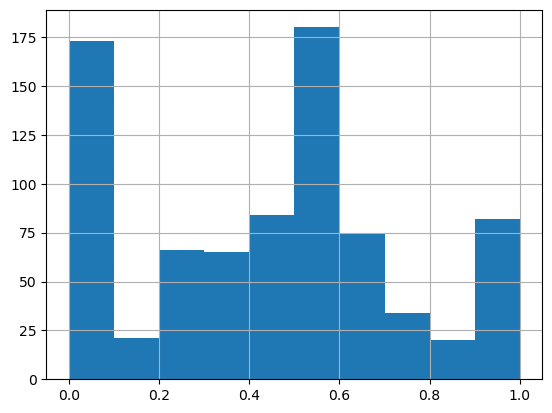

In [47]:
clean_features.is_polyploid_poly_frac.hist()

<AxesSubplot: >

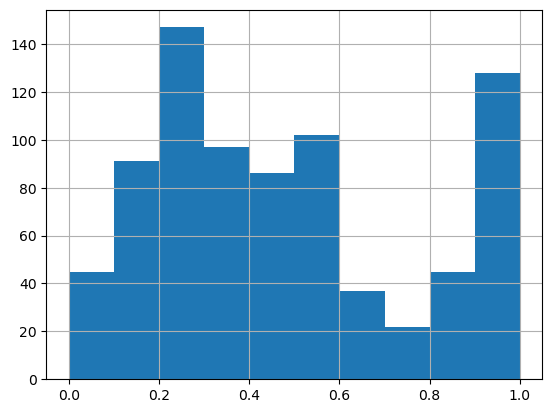

In [48]:
clean_features.is_polyploid_missing_frac.hist()

# save data

In [49]:
relevant_features = base_relevant_features + [f"null_standardized_{f}" for f in base_relevant_features]

In [50]:
clean_features = clean_features.drop_duplicates()
clean_features = clean_features.dropna(subset=relevant_features)
clean_features = clean_features.fillna(-1)
clean_features["has_polyploids"] = (clean_features.is_polyploid_poly_frac>0).astype(int)
print(f"# remaining records = {clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path)

# remaining records = 800


# devise plant-trait based features from plant trait data

In [51]:
plant_trait_cols = ['Growth_form', 'flw_shape_AST_head_level', 'n_flw_infl_AST_head_level','flw_symmetry_AST_head_level', 'mating_system']
plant_trait_data = pd.read_csv(plant_metadata_path)[["original_name"] + plant_trait_cols]   
plant_trait_data["is_herb"] = plant_trait_data.Growth_form.apply(lambda n: 1 if n == "herb" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_flw_rest"] = plant_trait_data.flw_shape_AST_head_level.apply(lambda n: 1 if n == "restrictive" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_multi_flw"] = plant_trait_data.n_flw_infl_AST_head_level.apply(lambda n: 1 if n == "multiple" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_symmetric"] = plant_trait_data.flw_symmetry_AST_head_level.apply(lambda n: 1 if n == "actinomorphic" else (np.nan if pd.isna(n) else 0))
plant_trait_data["is_sc"] = plant_trait_data.mating_system.apply(lambda n: 1 if "SC" in n else (np.nan if n=="unknown" else 0))

networks_metadata = pd.read_csv(networks_metadata_path)

In [52]:
def get_network_plants(network_path: str) -> list:
    try:
        net = pd.read_csv(network_path)
        if "Plant" not in net.columns:
            net = net.rename(columns={"Unnamed: 0": "Plant"})
        return net.Plant.str.lower().tolist()
    except Exception as e:
        print(network_path, e)
        return np.nan

def get_fracs_trait(plant_names: list, trait_dict: dict) -> list:
    plant_vals = np.array([trait_dict.get(p, np.nan) for p in plant_names])
    frac_ones = np.nansum(plant_vals) / sum(~np.isnan(plant_vals))
    frac_missing = sum(np.isnan(plant_vals))/len(plant_vals)
    return [frac_ones, frac_missing]
    
if "frac_flw_rest" not in networks_metadata.columns:
    networks_metadata["plants"] = networks_metadata.parallel_apply(lambda rec: get_network_plants(f"../../../data/networks/all/{rec.network_type}/{rec.network_index}.csv"), axis=1)
    for c in plant_trait_data.columns:
        if c.startswith("is_"):
            trait_dict = plant_trait_data.set_index("original_name")[c].to_dict()
            networks_metadata[[c.replace("is_", "frac_"), c.replace("is_", "frac_missing_")]] = networks_metadata.apply(lambda rec: get_fracs_trait(rec.plants, trait_dict=trait_dict), axis=1, result_type="expand")
            
networks_metadata["has_polyploids"] = (networks_metadata.is_polyploid_poly_frac > 0).astype(int)
if "plants" in networks_metadata.columns:
    networks_metadata.drop(["plants"], axis=1, inplace=True)
networks_metadata.to_csv(networks_metadata_path, index=False)

# merge with network metadata

In [53]:
networks_metadata = pd.read_csv(networks_metadata_path)
networks_metadata_rel_cols = [c for c in networks_metadata.columns if "frac" in c]
networks_metadata_rel_cols += ['Annual.Mean.Temperature', 
'Mean.Diurnal.Range..Mean.of.monthly..max.temp...min.temp..',
'Isothermality..BioClim_2.BioClim_7....100.',
'Temperature.Seasonality..standard.deviation..100.',
'Max.Temperature.of.Warmest.Month',
'Min.Temperature.of.Coldest.Month',
'Temperature.Annual.Range..BioClim_5.BioClim_6.',
'Mean.Temperature.of.Wettest.Quarter',
'Mean.Temperature.of.Driest.Quarter',
'Mean.Temperature.of.Warmest.Quarter',
'Mean.Temperature.of.Coldest.Quarter',
'Annual.Precipitation',
'Precipitation.of.Wettest.Month',
'Precipitation.of.Driest.Month',
'Precipitation.Seasonality..Coefficient.of.Variation.',
'Precipitation.of.Wettest.Quarter',
'Precipitation.of.Driest.Quarter',
'Precipitation.of.Warmest.Quarter',
'Precipitation.of.Coldest.Quarter',
'NPP', 
'Phosphorus.retention',
"EcoRegion", 
"EcoRegion_name",
"biome",
"area",
"Longitude", 
"Latitude", 
"location", 
"path",
"climate_category",
"species_richness", 
'Perennial.herb..', 
"Polyploid.percent", 
"highest_pollinator_rank_index",
'num_pollinators', 
'network_size', 
'num_plants',
'num_resolved',
'num_classified',
'num_polyploids',
'num_diploids']

clean_features = pd.read_csv(processed_data_path)
clean_features = clean_features[[c for c in clean_features.columns if not "Unnamed" in c]]

In [54]:
clean_features = clean_features.merge(networks_metadata[["network_index", "network_type"] + networks_metadata_rel_cols], on=["network_type", "network_index"], how="left")
clean_features = clean_features.rename(columns={c: c.replace("_y","") for c in clean_features.columns if c.endswith("_y")}).drop([c for c in clean_features.columns if c.endswith("_x")], axis=1)
clean_features.to_csv(processed_data_path, index=False)

# check how many records can be included in the analysis based on filtering criteria

In [55]:
# check how many of the networks with medata can be included in the analysis
clean_features = pd.read_csv(processed_data_path)
clean_features["included_in_analysis"] = clean_features.apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and rec.num_classified >= min_classified_threshold and rec.num_polyploids >= min_poly_threhold and rec.num_diploids >= min_di_threshold, axis=1)
relevant_networks = clean_features.query("included_in_analysis")
print(f"# networks relevant for analysis = {relevant_networks.shape[0]:,}")
only_networks_metadata_rel_cols = list(set(networks_metadata_rel_cols)-{"EcoRegion", "EcoRegion_name", "Longitude", "Latitude", "location"})
with_geo_relevant_networks = relevant_networks.dropna(subset=only_networks_metadata_rel_cols)
print(f"# networks relevant for analysis with metadata = {with_geo_relevant_networks.shape[0]:,}")

# networks relevant for analysis = 533
# networks relevant for analysis with metadata = 315


In [56]:
networks_metadata = pd.read_csv(networks_metadata_path)
metadata_cols = set(clean_features.columns)-set(networks_metadata.columns) - {'network_id',
                                                                              'weighted NODF','weighted connectance', 'modularity',
                                                                              'null_standardized_weighted NODF','null_standardized_weighted connectance','null_standardized_modularity'}
if len(metadata_cols) > 0:
    networks_metadata = networks_metadata.merge(clean_features[["EcoRegion_name"] + list(metadata_cols)], on="EcoRegion_name", how="left")

In [57]:
relevant_clean_features = clean_features.dropna(subset=networks_metadata_rel_cols)
print(f"# networks with available geodata = {relevant_clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path, index=False)

# networks with available geodata = 231


In [58]:
clean_features["path"] = clean_features.apply(lambda rec: networks_metadata.loc[(networks_metadata.network_index == rec.network_index) & (networks_metadata.network_type == rec.network_type)].path.values[0], axis=1)

In [59]:
clean_features[networks_metadata_rel_cols].notna().sum()

is_polyploid_poly_frac                                        800
is_polyploid_missing_frac                                     800
frac_herb                                                     720
frac_missing_herb                                             800
frac_flw_rest                                                 718
frac_missing_flw_rest                                         800
frac_multi_flw                                                718
frac_missing_multi_flw                                        800
frac_symmetric                                                717
frac_missing_symmetric                                        800
frac_sc                                                       644
frac_missing_sc                                               800
Annual.Mean.Temperature                                       736
Mean.Diurnal.Range..Mean.of.monthly..max.temp...min.temp..    736
Isothermality..BioClim_2.BioClim_7....100.                    736
Temperatur

# plot data

In [60]:
clean_features = pd.read_csv(processed_data_path)
clean_features["included_in_analysis"] = clean_features.apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and rec.num_classified >= min_classified_threshold and rec.num_polyploids >= min_poly_threhold and rec.num_diploids >= min_di_threshold, axis=1)
clean_features = clean_features.loc[clean_features.included_in_analysis]
clean_features.groupby("has_polyploids")["network_index", "num_plants", "num_classified", "num_polyploids"].agg({"network_index": lambda n: len(n),
                                                                                                                  "num_plants": np.mean,
                                                                                                                  "num_classified": np.mean,
                                                                                                                   "num_polyploids": np.mean}) 
                                                                                    

/tmp/ipykernel_39875/1458986359.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clean_features.groupby("has_polyploids")["network_index", "num_plants", "num_classified", "num_polyploids"].agg({"network_index": lambda n: len(n),


,network_index,num_plants,num_classified,num_polyploids
has_polyploids,,,,
0,34,9.294118,5.058824,1.705882
1,499,15.386774,9.803607,4.545090


In [61]:
clean_features.loc[clean_features.has_polyploids == 0].sort_values("num_classified")[["network_index", "network_size", "num_plants", "num_classified", "num_polyploids", "num_diploids"]]

,network_index,network_size,num_plants,num_classified,num_polyploids,num_diploids
182,264,33,3,3,3,0
212,279,96,6,3,2,1
21,198,42,7,3,3,0
559,722,72,6,3,0,3
53,453,153,9,3,2,1
64,212,54,6,3,2,1
519,720,24,4,3,0,3
291,192,72,4,3,0,3
114,479,114,6,3,1,2
88,472,96,8,3,2,1


In [62]:
clean_features = clean_features.loc[(clean_features.is_polyploid_missing_frac <= max_missing_threshold) &
                                    (clean_features.num_classified >= min_classified_threshold) &
                                    (clean_features.num_polyploids >= min_poly_threhold) &
                                    (clean_features.num_diploids >= min_di_threshold)] 
print(f"# networks for analysis = {clean_features.shape[0]:,}")

# networks for analysis = 533


/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


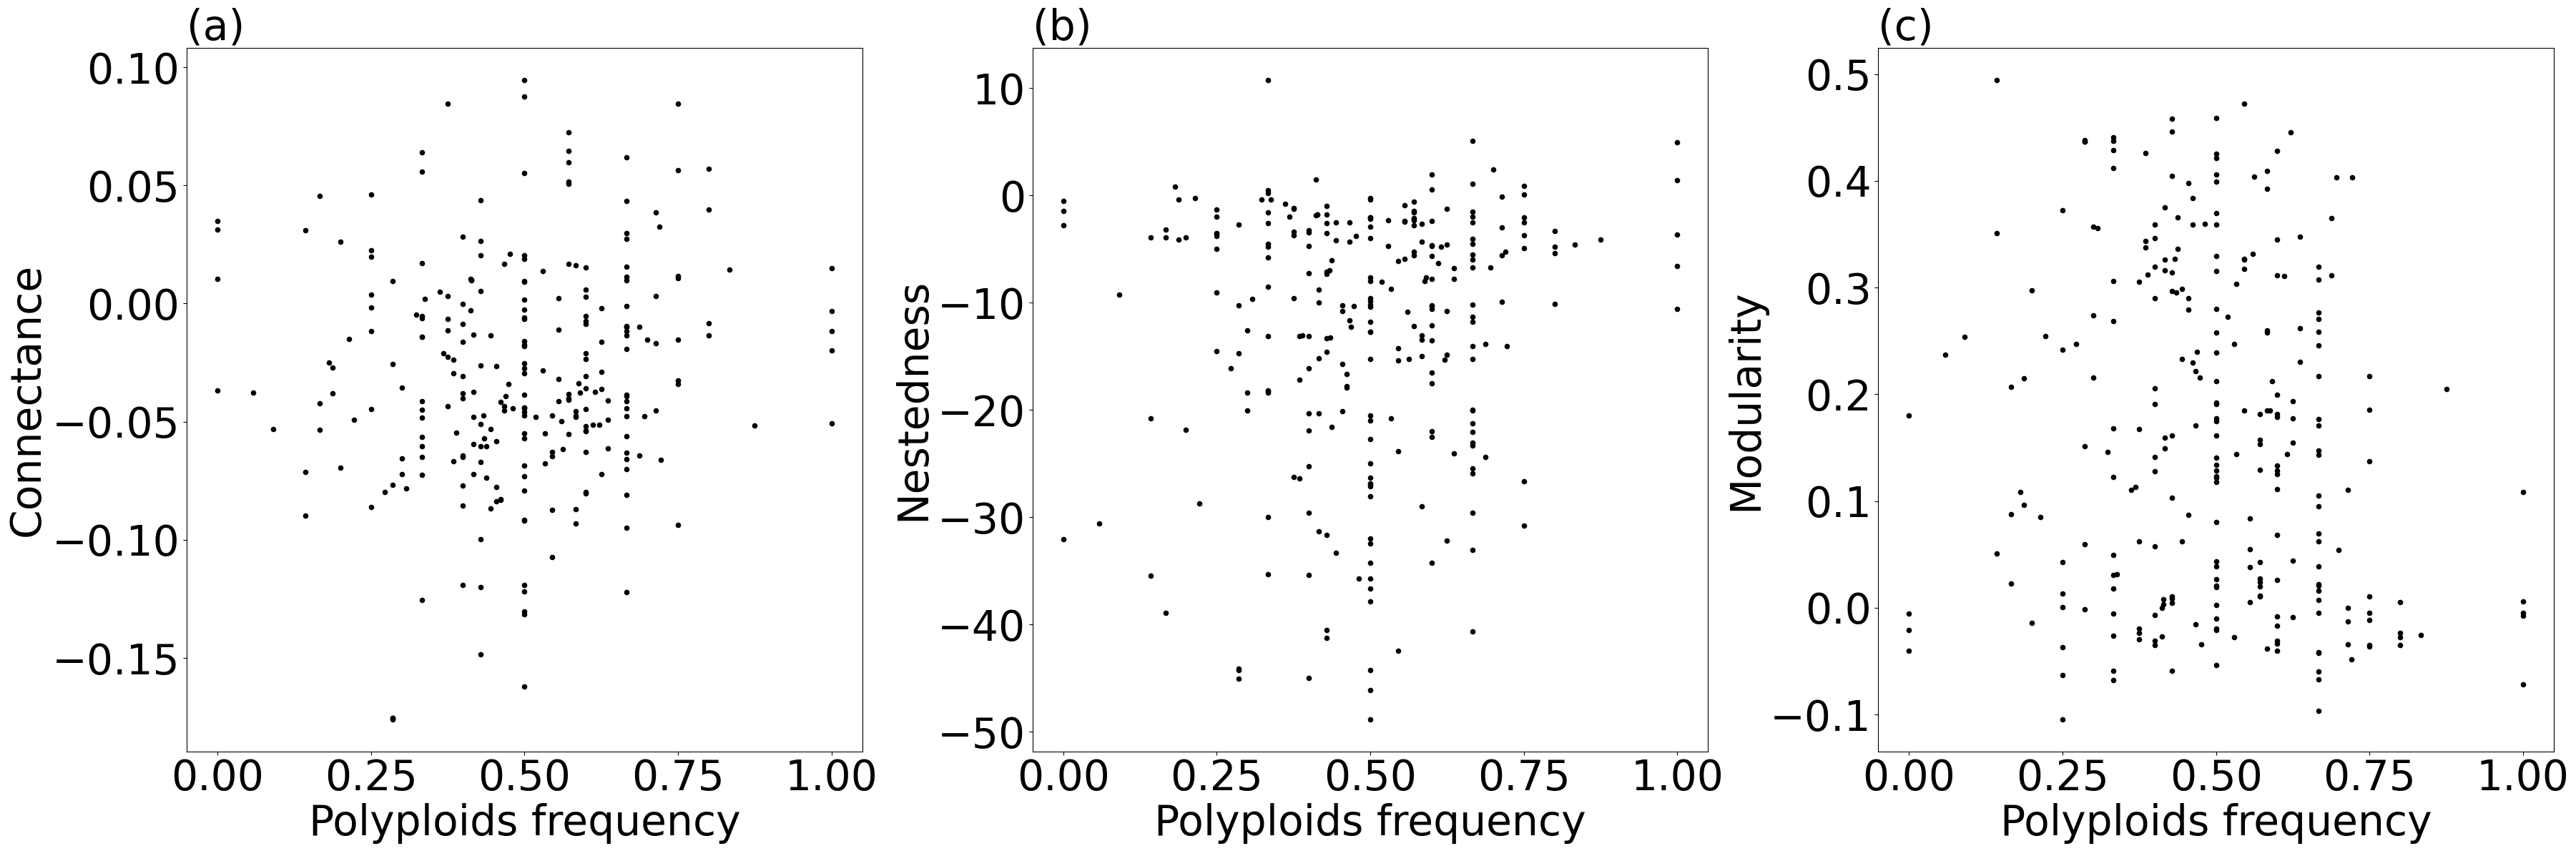

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42

plotting_features = clean_features#.loc[(clean_features.is_polyploid_missing_frac <= missing_data_threshold) & (clean_features.num_classified >= n_classified_threshold)]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))
plotting_features = clean_features.loc[clean_features.is_polyploid_missing_frac <= 0.3]

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted connectance", ax=ax1, color="black")
ax1.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)


ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted NODF", ax=ax2, color="black")
ax2.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)


ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_modularity", ax=ax3, color="black")
ax3.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")

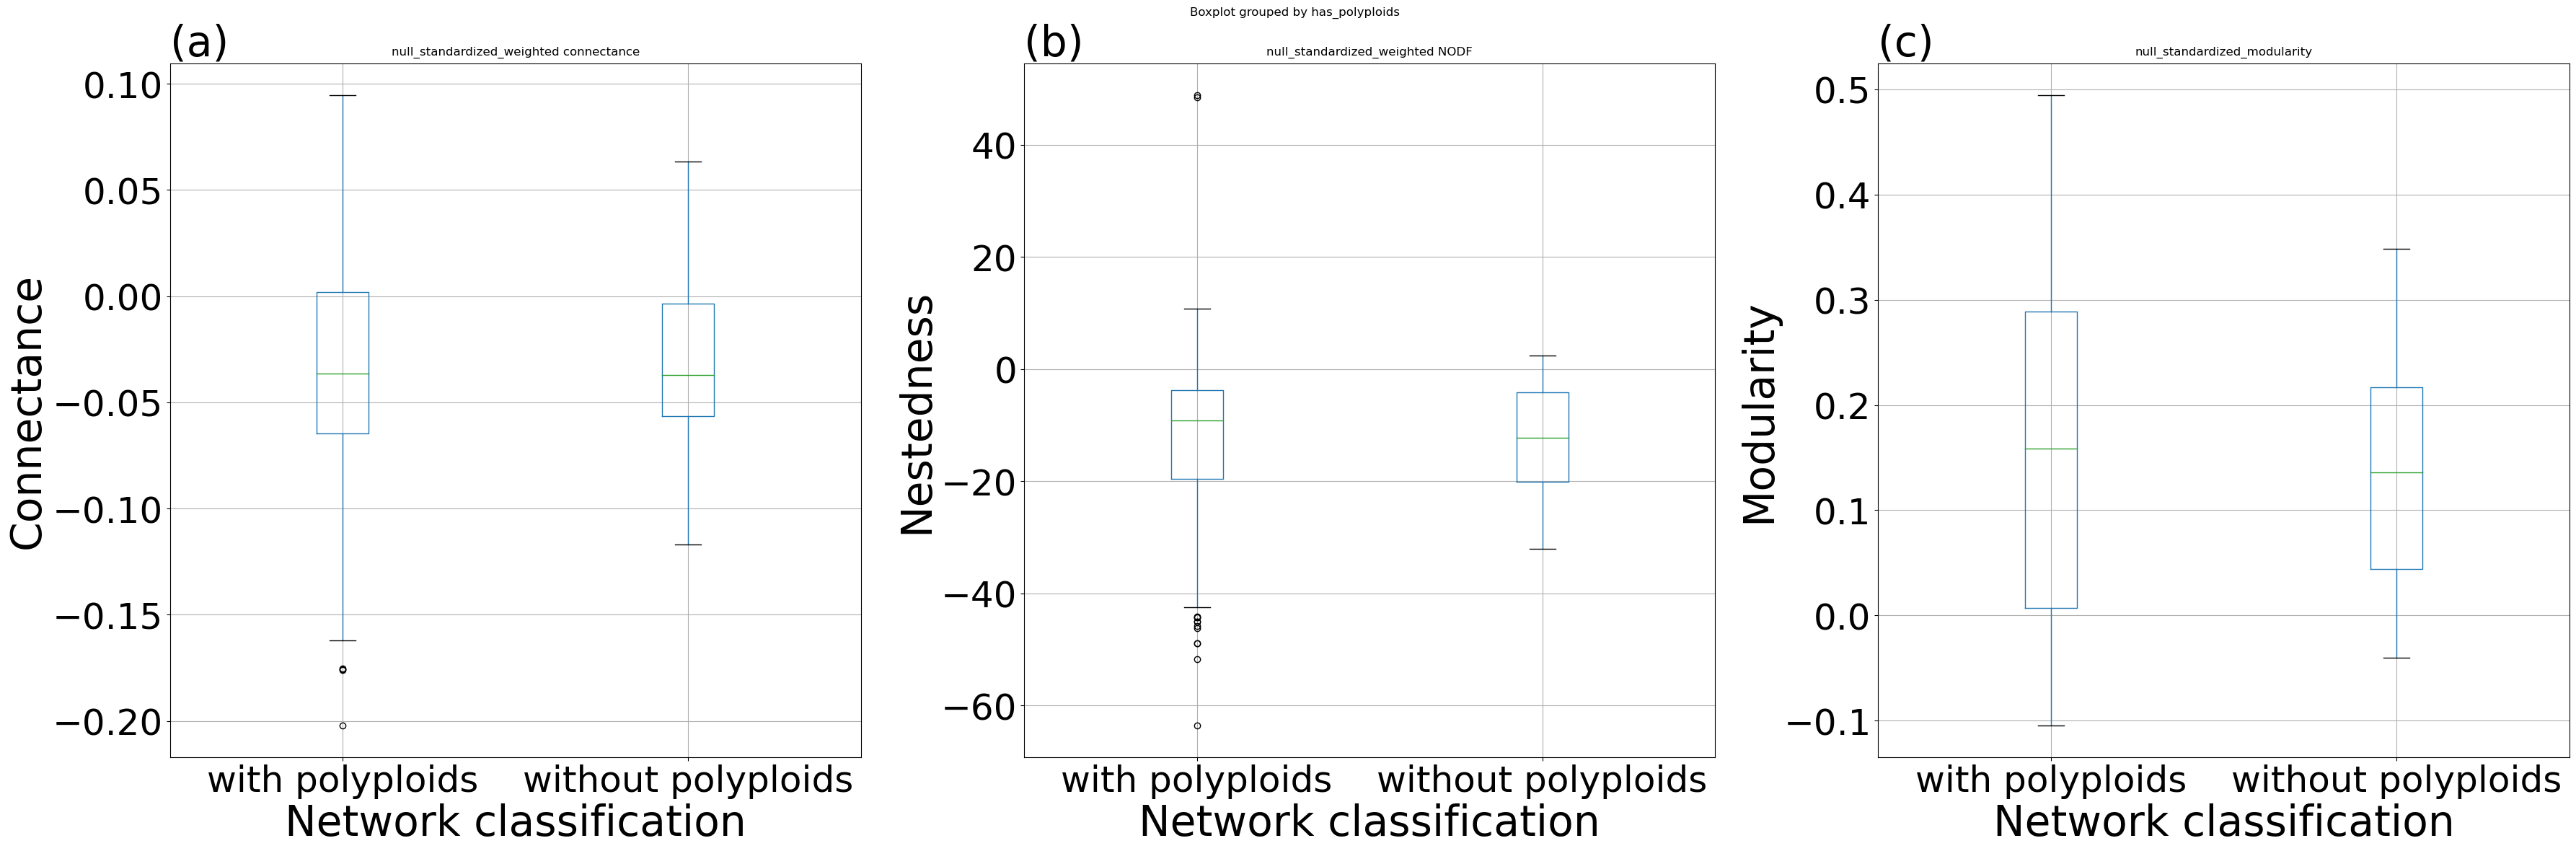

In [64]:
plotting_features = clean_features.copy()
plotting_features.has_polyploids = plotting_features.has_polyploids.replace({0: "without polyploids", 1: "with polyploids"}) 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "null_standardized_weighted connectance"]].boxplot(by="has_polyploids", ax=ax1)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.set_xlabel("Network classification",  fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize-6)

ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "null_standardized_weighted NODF"]].boxplot(by="has_polyploids", ax=ax2)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.set_xlabel("Network classification",  fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-6)

ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features[["has_polyploids", "null_standardized_modularity"]].boxplot(by="has_polyploids", ax=ax3)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.set_xlabel("Network classification",  fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize-6)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize-6)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig4_{'binary' if not do_weighted else 'weighted'}.jpeg")

In [65]:
from scipy import stats

conc_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "null_standardized_weighted connectance"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "null_standardized_weighted connectance"].values)

nest_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "null_standardized_weighted NODF"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "null_standardized_weighted NODF"].values)

mod_res = stats.kruskal(clean_features.loc[clean_features.has_polyploids == 0, "null_standardized_modularity"].values, 
                         clean_features.loc[clean_features.has_polyploids == 1, "null_standardized_modularity"].values)

In [66]:
conc_res

KruskalResult(statistic=0.007253105020254225, pvalue=0.9321300856786221)

In [67]:
nest_res

KruskalResult(statistic=0.7194415268077137, pvalue=0.39632715958796993)

In [68]:
mod_res

KruskalResult(statistic=0.35815186221748263, pvalue=0.5495344397086499)

# conduct pairwise correrlations analysis on all the included features with respect to:
## 1. all the data
## 2. only analyzed data

In [177]:
df = pd.read_csv(processed_data_path)

In [178]:
df['included_in_analysis'] = df.parallel_apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and
                                               rec.num_classified > min_classified_threshold and
                                               rec.num_polyploids >= min_poly_threhold and
                                               rec.num_diploids >= min_di_threshold, axis=1)                             

In [180]:
features = [c for c in df.columns if not "weighted" in c and not "null" in c and not "bc_" in c and not "rk_id" in c and c != "modularity" and not "num_" in c and not "is_" in c and not "type" in c and not "Paleo" in c and not "Quarter" in c]

rel_features = ["is_polyploid_poly_frac", "Climate_PC1", "Climate_PC2", "Climate_PC3",
                    "network_size", "species_richness", "pd",
                    'Perennial.herb..', "Polyploid.percent"]
df.query("included_in_analysis")[rel_features].notna().sum()

is_polyploid_poly_frac    298
Climate_PC1               248
Climate_PC2               248
Climate_PC3               248
network_size              298
species_richness          248
pd                        298
Perennial.herb..          248
Polyploid.percent         248
dtype: int64

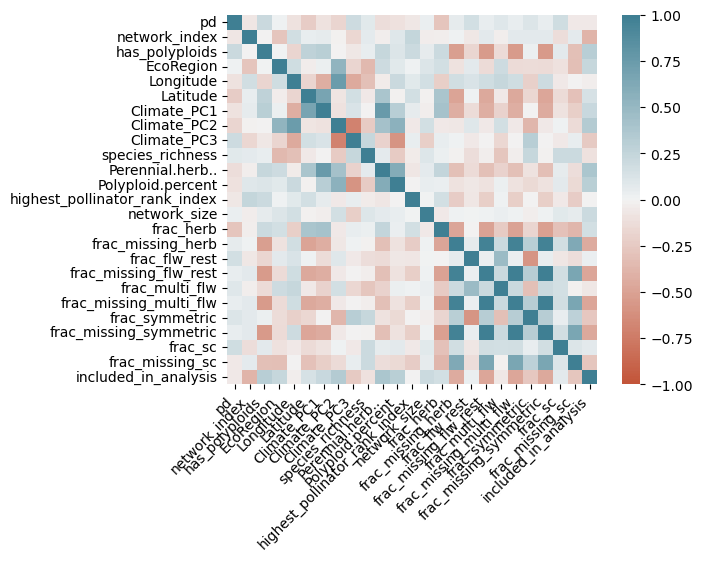

In [181]:
# do pairwise corrrelations test
all_corr = df[features].corr()

ax = sns.heatmap(
    all_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

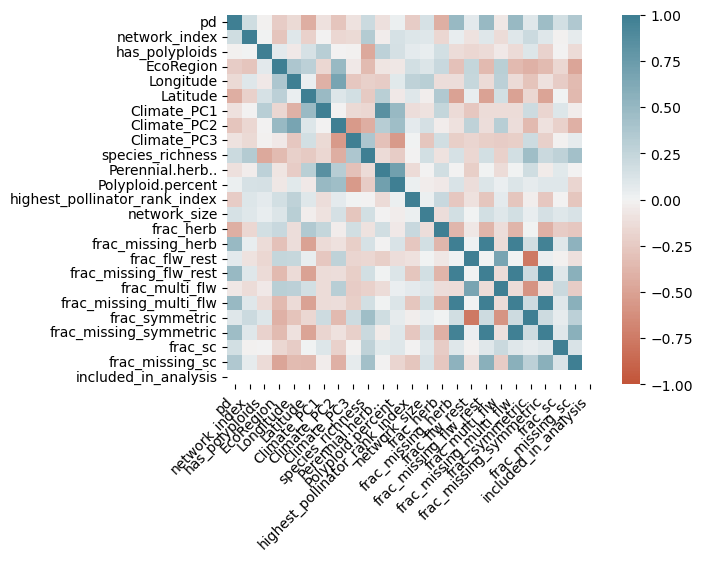

In [182]:
# do pairwise corrrelations test
an_corr = df.query("included_in_analysis")[features].corr()

ax = sns.heatmap(
    an_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

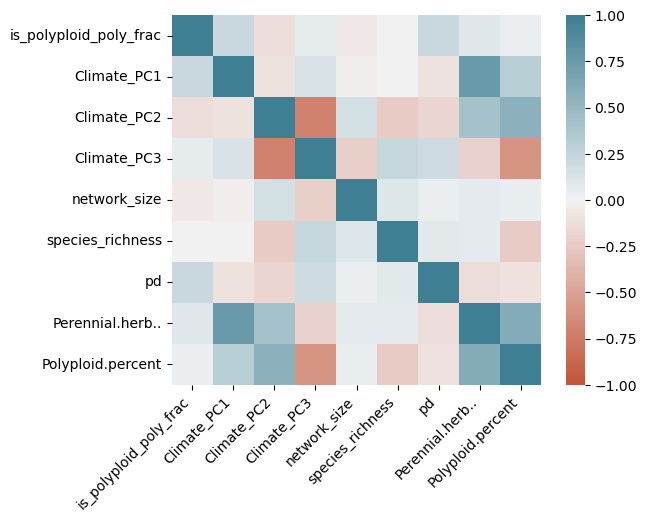

In [183]:
# do pairwise corrrelations test
all_corr_only_rel = df[rel_features].corr()

ax = sns.heatmap(
    all_corr_only_rel, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

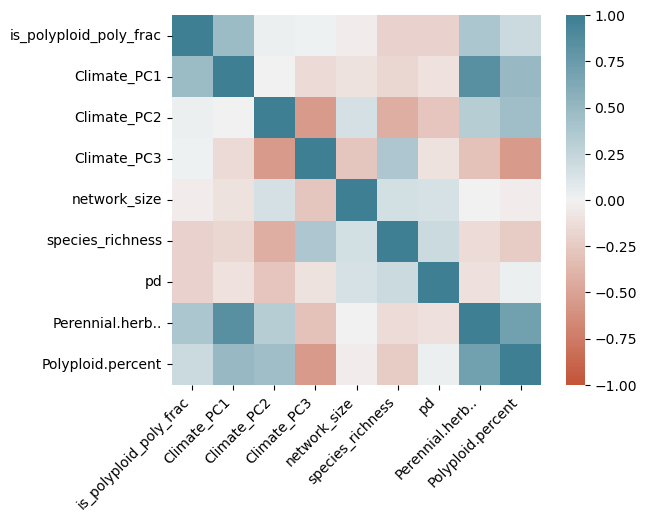

In [184]:
# do pairwise corrrelations test
an_corr_only_rel = df.query("included_in_analysis")[rel_features].corr()

ax = sns.heatmap(
    an_corr_only_rel, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [185]:
# report features with absolute correlation >= 0.9
high_corr_indices = np.where(np.abs(all_corr_only_rel) >= 0.9)
highly_corr_feautres = [(rel_features[high_corr_indices[0][i]],rel_features[high_corr_indices[1][i]]) for i in range(len(high_corr_indices[0])) if high_corr_indices[0][i] > high_corr_indices[1][i]]
print("highly correlated pairs of features: \n", '\n'.join([",".join(i) for i in highly_corr_feautres]))

highly correlated pairs of features: 
 


In [186]:
# report features with absolute correlation >= 0.9
high_corr_indices = np.where(np.abs(all_corr) >= 0.9)
highly_corr_feautres = [(features[high_corr_indices[0][i]],features[high_corr_indices[1][i]]) for i in range(len(high_corr_indices[0])) if high_corr_indices[0][i] > high_corr_indices[1][i]]
print("highly correlated pairs of features: \n", '\n'.join([",".join(i) for i in highly_corr_feautres]))

highly correlated pairs of features: 
 frac_herb,highest_pollinator_rank_index
frac_flw_rest,highest_pollinator_rank_index
frac_flw_rest,frac_herb
frac_multi_flw,highest_pollinator_rank_index
frac_multi_flw,frac_herb
frac_multi_flw,frac_flw_rest


In [187]:
df.query("included_in_analysis").drop_duplicates("network_id")[rel_features].notna().sum()

is_polyploid_poly_frac    298
Climate_PC1               248
Climate_PC2               248
Climate_PC3               248
network_size              298
species_richness          248
pd                        298
Perennial.herb..          248
Polyploid.percent         248
dtype: int64